
# Project 3: Classifying a Reddit post - Classification


--- 
# Part 2

### Pre-processing, Random Forest and SVC model evaluation, visualizations

---

### Contents:
- [Modelling](#Modelling)
- [The Data](#The-Data)
- [Get Data from Reddit](#Get-Data-from-Reddit)
- [Data Cleaning and EDA](#Data-Cleaning-and-EDA)
- [Deep Dive on Random Forest](#Deep-Dive-on-Random-Forest)
- [Deep Dive on Support Vector Classifier](#Deep-Dive-on-Support-Vector-Classifier)
- [Visualizations](#Visualizations)

#### 
- Preprocessing:
**NLP and Classification:** 
Getting the reddit data using Pushshift
After doing the preliminary EDA, the only columns of interest are the Title and selftext (body).   

2 main areas to investigate: 
1. Whether to tokenize title, selftext or both
2. Not surprisingly, there are many words in common between the two subreddits. How do we figure out the list of stop words that the classifier can ignore? How many tokens should we use in our stop word list - just the default english (that comes from sklearn), the Top 100 or the Top 1000 common across both subreddits? (pickled the stop_words file for access by GridSearch)

Use the CountVectorizer and TF-IDF Transformer to vectorize the title and selftext, then tried multiple Classifiers using a two-step approach. 
In the first step, using GridSearch, I determined the optimal parameters for CountVectorizer and each of the classifiers - Random Forest, Support Vector Classifier (SVC), KNN and Extra Trees Classifier. 

**Psuedo-Hyperparameters:**

Do we tokenize title, or selftext or both? 
How many stop words to use: 10, 100, 1000? 
Hmmm, these smell like hyper-parameters  - these are my pseudo-hyper-parameters!

I then tried out all 9 combinations of (title, selftext, title_selftext with english, Top 100 and Top 1000 stop words) in a neat little MetaGridSearch function, obtained all the classification metrics and stored the results in a dataframe, for each of the four classifiers. Each of these was written to disk and then later merged together to create a composite results dataframe for comparing all the models. 





## Modelling <a class="anchor" id="Modelling"></a>

How do we predict which subreddit (of the two specfied) a post belongs to?   
We will use multiple classification models: Random Forest, SVC, KNN and ExtremeTree Classifiers.   
A framework has been created to easily iterate through multiple models and compare their results, all with just a few lines of code. We could easily model many more models (but will keep that for the future).  


From our EDA, we realized we need to figure out whether to just use the Title from a reddit submission or the selftext or a combination of both. 
We are also trying to figure out which Stop Words are the best - the default ENGLISH_STOP_WORDS from sklearn, or the Top 100 or Top 1000 common words across both the subreddits. 

GridSearch obviously doesn't consider the column of text as a hyperparameter, so we have to loop through it ourselves.

We could pass the different stop words options as pipe parms, but then we get back the result only for the one that performs best from an accuracy perspective. 
We will not be able to get the detailed classification metrics for each of the combinations. 

Hence **MetaGridSearch!**   
The MetaGridSearch framework does exactly as the name implies. It loops over the parameters which are not hyperparmeters, and then calls GridSearch

It calls model and then calls evaluate_model. It gets the results for each iteration and appends them to a full_results dataframe, which is returned back from this function




#### **Model Evaluation:** 
After analyzing the classification metrics with various visualizations, deciding which ones are the most relevant in our scenario. 



In [1]:
# Imports:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, plot_roc_curve, roc_auc_score, precision_score, f1_score, recall_score, roc_curve

import pickle
import time
import seaborn as sns


#### Have created a number of functions to make the processing much simpler
prepare_df(file1, file2): returns combined_df  
model ( X, y, pipe, pipe_params): returns GridSearch obj   
read_stop_words(file_name): returns the list of stop words from a file  
evaluate_model(gs, df_column_text_type, stop_word_type, preds, preds_prob): returns a dataframe containing all the classification metrics  



Read the two subreddit files, drop Unnamed column, merge into one dataframe, drop nulls, map target to numeric.  
Returns combined_df


In [2]:
# Function to read the running and c25k files, merge and return the combined datafrome

def prepare_df(file1, file2 ):
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    df1.drop( columns="Unnamed: 0", inplace=True)     # if error, how to ignore?
    df2.drop( columns="Unnamed: 0", inplace=True)
    
    print( f"Shape df1: {df1.shape}, df2: {df2.shape}")


    # combine into merged dataframe
    combined_df = df1.append(df2, ignore_index=True)
    
    # convert subbreddit col to numeric
    combined_df['subreddit'] = combined_df['subreddit'].map({
                                    "running": 1, # can generalize later if needed
                                    "C25K" : 0
                                    })
    
    # drop the 288 rows containing null selftexts, since we're using both title+selftext
    combined_df.dropna(inplace=True) 
    
    # create new column combining the title and body (selftext)
    combined_df['title_selftext'] = combined_df["title"] + ".\\n" + combined_df["selftext"]

    print( f"Shape combined: {combined_df.shape}")
    return combined_df

In [3]:
# Call the function. Pass in the two files saved from reading the reddit data

combined_df = prepare_df("../data/running.csv", "../data/c25k.csv" )

Shape df1: (9915, 9), df2: (4337, 9)
Shape combined: (13940, 10)


In [4]:
#combined_df

#### Split, instantiate model, fit
This is the one that calls the sklearn GridSearch.  
Returns the gridsearch object for model evaluation

In [5]:
# modeling and fit

def model ( X, y, pipe, pipe_params):
    
    global X_train, X_test, y_train, y_test # to update global varibale for use by rest of notebook
    
    X_train, X_test, y_train, y_test = train_test_split( X, y, stratify = y, random_state = 42)

    # Start our timer.
    t0 = time.time()

    # Instantiate GridSearchCV.
    gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5, verbose=1, n_jobs=6)

    # Fit and transform GridSearch to training data.
    gs.fit(X_train, y_train)

    # Stop our timer and print the result.
    print(f"Time taken: {time.time() - t0} secs")

    return gs



#### Function to read stop_words list pickled data from file
Returns the stop words list 

In [6]:

def read_stop_words(file_name):

    if file_name == 'english':  # if 'english' use the stop_words from sk_learn
        stop_words_list = 'english'
    else:
        with open( file_name, 'rb') as f:
            stop_words_list = pickle.load(f)
        
#    print( f"Length of stop_words_list: {len(stop_words_list)}")
    return stop_words_list

        

#### Nice helper function which collects all the classification metrics in one dataframe

In [7]:
# Evaluate model, return results_df 

def evaluate_model(gs, df_column_text_type, stop_word_type, preds, preds_prob):

    # not using col_list any more...
#    col_list = [[
#        "Reddit Text Type", "Stop Word Type", 
#        "Baseline Score", "Training Score", "Test Score", "Variance of Test vs Training Score", "TN", "FP", "FN", "TP", 
#        "Accuracy", "Sensitivity", "Specificity", "Precision", 
#        "F1 Score", "ROC AUC Score", "Best Score" #, "Best Params"
#    ]]

#    print( f"Evaluate:  {df_column_text_type}, {stop_word_type}" )

    results_df = pd.DataFrame()    
#    results_df = pd.DataFrame(columns = col_list )


    results_df["Reddit Text Type"] = [df_column_text_type] # title, selftext or Both
    results_df["Stop Word Type"] = [stop_word_type] # "english", Top 100, or Top 1000

#    print( results_df["Reddit Text Type"], results_df["Stop Word Type"] )

    # baseline
    results_df["Baseline Score"] = [y_test.value_counts(normalize = True)[1]]
#    print( f"Baseline Score: \n{y_test.value_counts(normalize = True)}")
    
    
    # Score model on training set.
    results_df["Training Score"] = [gs.score(X_train, y_train)]
#    print(f'Training Score: {gs.score(X_train, y_train)}')

    # Score model on testing set.
    results_df["Test Score"] = [gs.score(X_test, y_test)]
#    print(f'Testing Score: {gs.score(X_test, y_test)}')

    # Create a column that contains the percent difference between the Training and Test Score. This measures our variance (lower the better)
    results_df["Variance of Test vs Training Score"] = (results_df["Training Score"]-results_df["Test Score"])/results_df["Training Score"]*100

    ## Create variable to store confusion matrix
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()
    
    results_df["TN"] = [tn]
    results_df["FP"] = [fp]
    results_df["FN"] = [fn]
    results_df["TP"] = [tp]
        
    accuracy = (tp + tn) / (tp + fn + fp + tn)
    results_df["Accuracy"] = [accuracy]
    
    sensitivity = tp /(tp + fn)
    results_df["Sensitivity"] = [sensitivity]


    specificity = (tn)/(tn+fp)
    results_df["Specificity"] = [specificity]


    precision = tp / (tp + fp)
    results_df["Precision"] = [precision]

    f1 = f1_score(y_test, preds)
    results_df["F1 Score"] = [f1]
             
    # calculate AUC
    roc = roc_auc_score(y_test, preds_prob)
    results_df["ROC AUC Score"] = [roc]
    
    # calculate cross-validated AUC
##    cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

    # Check params
    results_df["Best Score"] = [gs.best_score_]
#    results_df["Best Params"] = gs.best_params_

#    print( f"Evaluate:\\n {results_df}\\n Returning from evaluate.")

    return results_df



#### The MetaGridSearch does exactly as the name implies. It loops over the parameters which are not hyperparmeters, and then calls GridSearch

We are trying to figure out whether to just use the Title from a reddit submission or the selftext or a combination of both. 
We are also trying to figure out which Stop Words are the best - the default ENGLISH_STOP_WORDS from sklearn, or the Top 100 or Top 1000 common words across both the subreddits. 

GridSearch obviously doesn't consider the column of text as a hyperparameter, so we have to loop through it ourselves.

We could pass the different stop words options as pipe parms, but then we get back the result only for the one that performs best from an accuracy perspective. 
We will not be able to get the detailed classificstion metrics for each of the combinations. 

Hence MetaGridSearch! 

    
It calls model and then calls evaluate_model. It gets the results for each iteration and appends them to a full_results dataframe, which is returned back from this function




In [8]:
# Super cool meta function, iterate over GridSearch by model, subreddit text type, stop words
# Can skip the Meta part of iterating over all the Reddit Text Types and Stop Word types 
# by setting the best parameter to True

# return list of results 

def MetaGridSearch( pipe, pipe_params, best=False):

    #CountVectorize, TFIDVectorize, pipeline, evalaute
    global gs_list
    gs_list = []
    full_results_df = pd.DataFrame()

    y = combined_df["subreddit"]
    stop_word_types = ["english", "Top 100", "Top 1000"]


    if best == False: #  (default)
        df_column_names = ['title', 'selftext', 'title_selftext']

        files = [['english', r'../data/stop_words_100_title.pkl', r'../data/stop_words_1000_title.pkl'],
                ['english', r'../data/stop_words_100_body.pkl', r'../data/stop_words_1000_body.pkl'],
                ['english', r'../data/stop_words_100_t_s.pkl', r'../data/stop_words_1000_t_s.pkl']]
    else: # only do one iteration with the known best params
        
        df_column_names = ['title_selftext']

        files = [['english', r'../data/stop_words_100_t_s.pkl']]
    

        
    # loop 9 times - for each of the 3 test types( title, selftext and title_selftext) do for each of the 3 stop-words (english, 100, 1000)
    for df_idx, df_column_name in enumerate( df_column_names ): # go through the 3 dfs
        for stop_idx, stop_word_file in enumerate( files[df_idx]) :  # pick the corresponding stop word file
            
            # display so we know how much is done (and more importantly how much is left!)
            total = len(df_column_names)* len(files[0])
            current = (df_idx)*3 + stop_idx + 1
            print( f"Loop: {current} out of {total}") 
            
            stop_words_list = read_stop_words(stop_word_file)
            stop_word_type = stop_word_types[stop_idx] # pass the stop word type name for results 

            # set X 
            X = combined_df[df_column_name] # df containing data for one column - either title, selftext or both
            
            
            # set stop)words in the pipe_params: for naow assume it is cvec__stop_words; maybe do lookup by value = 'english'
            pipe_params['cvec__stop_words'] = [stop_words_list]
            
            # call the model for each df, stop_words
            gs = model( X, y, pipe, pipe_params )


            preds = gs.predict(X_test)

            preds_prob = gs.predict_proba(X_test)[:,1] # 2nd column has the predicted prob of majority class ('running')

            #evaluate model 
            results_df = evaluate_model(gs, df_column_name, stop_word_type, preds, preds_prob) # put results by each of the 9 combinations
            
#            print( f"Meta: Back from Evaluate:\\n {results_df}\\n Returned from evaluate.")

#            print( f"Meta: appending to full_results_df: {df_idx}, {stop_idx}, {results_df.info()}" )
            full_results_df = full_results_df.append(results_df, ignore_index=True)

#            print( f"Meta: appended to full_results_df: {df_idx}, {stop_idx}, {full_results_df.info()}" )
            
            gs_list.append(gs) # if needed for later

    print("Done!")
    return full_results_df


#### Now actually initiate the modeling - this is for Random Forest
The optimal parameters have already been determined by much GridSearch. We now use the optimal parameters (only hyperparameter tuning is alpha, just to show the tuning)
This creates the desired pipeline and sets the pipe parameters then calls the super cool MetaGridSearch 

All the metrics for the model evaluation are returned in a dataframe which is written to file for easy comparison across models

In [9]:

# This is for RandomForest, but can be easily used for any Estimator/Pipeline

cvec_idf_rf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf' , TfidfTransformer()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_params = {

#        'cvec__ngram_range' : [(1, 3), (1, 2)],
# optimal params
        'cvec__max_df' : [ 0.97],
        'cvec__max_features' : [ 4000],    
        'cvec__min_df' : [ 2], 
        'cvec__stop_words' : ["english"],  # This is overridden by MetaGridSearch
        'rf__ccp_alpha': [ 0.0001, 0.001],    
        'rf__max_depth' : [ 70],
        'rf__min_samples_leaf': [ 1], 
        'rf__min_samples_split': [ 3],
        'tfidf__use_idf': [True]

}

# call the meta function to iterate over all combinations

full_results_df = MetaGridSearch(cvec_idf_rf_pipe, pipe_params, best = False)

# add the model name to easily combine all the files later

full_results_df["Model"]= ["RandomForest"]*len(full_results_df)

# save the Random Forest classification metric results to file. 
full_results_df.to_csv("../data/rf_results_df.csv")
#full_results_df

# Now also do just for the best params so we can deep dive 
best_full_results_df = MetaGridSearch(cvec_idf_rf_pipe, pipe_params, best = True)

# Make a copy of X_train, X_test, y_train, y_test, gs for our deep dive. From these, we can do all our deep dive. 
# Ideally I wanted to do all the deep dive in a different notebook, but then it was getting complicated with 
# either creating python scripts where these functions could be accessed or I have to pickle these best dataframes 
# and read them from the other notebook. So, for now, will use these best_dfs in this notebook itself
# The good news is that there is only one copy of the code and it's being re-used quite elegantly (if I may so myself)

best_rf_X_train = X_train.copy()
best_rf_X_test = X_test.copy()
best_rf_y_train = y_train.copy()
best_rf_y_test = y_test.copy()

best_rf_gs = gs_list.copy()





Loop: 1 out of 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time taken: 6.325897932052612 secs
Loop: 2 out of 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time taken: 3.79318904876709 secs
Loop: 3 out of 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time taken: 2.2256717681884766 secs
Loop: 4 out of 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time taken: 16.04504704475403 secs
Loop: 5 out of 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time taken: 11.900453090667725 secs
Loop: 6 out of 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time taken: 6.834589004516602 secs
Loop: 7 out of 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time taken: 16.416369915008545 secs
Loop: 8 out of 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time taken: 12.695267915725708 secs
Loop: 9 out of 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['running'] not in stop_words.
  warnings.warn(


Time taken: 7.4955010414123535 secs
Done!
Loop: 1 out of 2
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time taken: 16.46951699256897 secs
Loop: 2 out of 2
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time taken: 12.657367944717407 secs
Done!


In [10]:
# Check params
#print( f"Best Params: \n{gs.best_params_}\n" )
#print( f"Best Score: \n{gs.best_score_}\n" )

#gs.get_params

#### And equally easily, do for SVC!!


#### Just need to set the params specific to this classifier and the metrics are available in file and in a df for convenient access

In [11]:
# SVC 

cvec_idf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf' , TfidfTransformer()),
    ('svc', SVC(random_state=42, max_iter=5000))
])


# Search over the following values of hyperparameters:
pipe_params = {

# optimal params
        'cvec__max_df' : [ 0.97],
        'cvec__max_features' : [ 4000],    
        'cvec__min_df' : [ 2 ], 
        'cvec__stop_words' : ['english'], # this gets overridden in MetaGridSearch
    
        'svc__C': [0.8889],
        'svc__degree' : [2 ],
        'svc__kernel' : [ 'sigmoid'],
        'svc__probability' : [ True ],    
        'tfidf__use_idf': [True]

}


# call the meta function 

svc_full_results_df = MetaGridSearch(cvec_idf_pipe, pipe_params)

# add the model name to easily combine all the files later

svc_full_results_df["Model"]= ["SVC"]*len(svc_full_results_df)


# save the ExtraTrees results to (a different) file. 
svc_full_results_df.to_csv("../data/svc_results_df.csv")
#svc_full_results_df

# Now also do just for the best params so we can deep dive 
best_svc_full_results_df = MetaGridSearch(cvec_idf_pipe, pipe_params, best = True)

# Make a copy of X_train, X_test, y_train, y_test, gs for our deep dive. From these, we can do all our deep dive. 
# Ideally I wanted to do all the deep dive in a different notebook, but then it was getting complicated with 
# either creating python scripts where these functions could be accessed or I have to pickle these best dataframes 
# and read them from the other notebook. So, for now, will use these best_dfs in this notebook itself
# The good news is that there is only one copy of the code and it's being re-used quite elegantly (if I may so myself)

best_svc_X_train = X_train.copy()
best_svc_X_test = X_test.copy()
best_svc_y_train = y_train.copy()
best_svc_y_test = y_test.copy()

best_svc_gs = gs_list.copy()





Loop: 1 out of 9
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Time taken: 21.91363501548767 secs
Loop: 2 out of 9
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Time taken: 19.742978811264038 secs
Loop: 3 out of 9
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Time taken: 16.00813603401184 secs
Loop: 4 out of 9
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Time taken: 99.6763699054718 secs
Loop: 5 out of 9
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Time taken: 75.01432180404663 secs
Loop: 6 out of 9
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Time taken: 45.50762605667114 secs
Loop: 7 out of 9
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Time taken: 100.71134424209595 secs
Loop: 8 out of 9
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Time taken: 77.25981998443604 secs
Loop: 9 out of 9
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['running'] not in stop_words.
  warnings.warn(
/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Time taken: 48.294241189956665 secs
Done!
Loop: 1 out of 2
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Time taken: 96.98683166503906 secs
Loop: 2 out of 2
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Time taken: 76.19728493690491 secs
Done!


#### Similarly, do for KNN!!

In [12]:
# KNN 



cvec_idf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf' , TfidfTransformer()),
    ('knn', KNeighborsClassifier())
])


# Search over the following values of hyperparameters:
pipe_params = {

# optimal params
        'cvec__max_df' : [ 0.97],
        'cvec__max_features' : [ 6000],    
        'cvec__min_df' : [ 2 ], 
        'cvec__stop_words' : ['english'], # this gets overridden in MetaGridSearch

        'knn__n_neighbors': [ 11, 25, 35 ], # from optimaizing on KNN 
        'knn__weights' : ["uniform", "distance"],

        'tfidf__use_idf': [True]
}

# call the meta funct../data/

knn_full_results_df = MetaGridSearch(cvec_idf_pipe, pipe_params)

# add the model name to easily combine all the files later

knn_full_results_df["Model"]= ["KNN"]*len(knn_full_results_df)


# save the KNN results to (a different) file. 
knn_full_results_df.to_csv("../data/knn_results_df.csv")
#knn_full_results_df

# Not doing a deep dive on KNN, so don't need to save details for the best set of params
best_knn_X_train = X_train.copy()
best_knn_X_test = X_test.copy()
best_knn_y_train = y_train.copy()
best_knn_y_test = y_test.copy()

best_knn_gs = gs_list.copy()




Loop: 1 out of 9
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Time taken: 4.81593918800354 secs
Loop: 2 out of 9
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Time taken: 5.079097032546997 secs
Loop: 3 out of 9
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Time taken: 3.827448844909668 secs
Loop: 4 out of 9
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Time taken: 15.309106826782227 secs
Loop: 5 out of 9
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Time taken: 11.59425401687622 secs
Loop: 6 out of 9
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Time taken: 9.58463716506958 secs
Loop: 7 out of 9
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Time taken: 14.126121044158936 secs
Loop: 8 out of 9
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Time taken: 11.99202013015747 secs
Loop: 9 out of 9
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['running'] not in stop_words.
  warnings.warn(


Time taken: 10.395648956298828 secs
Done!


#### And finally do for ExtremeTreesClassifier


In [13]:
# ExtremeTrees 


cvec_idf_rf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf' , TfidfTransformer()),
    ('et', ExtraTreesClassifier(random_state=42))
])

pipe_params = {

# optimal params
        'cvec__max_df' : [ 0.97],
        'cvec__max_features' : [ 4000],    
        'cvec__min_df' : [ 2], 
        'cvec__stop_words' : ["english"],  # This is overridden by MetaGridSearch

        'et__ccp_alpha': [ 0.0001, 0.001],    
        'et__max_depth' : [ 70],
        'et__min_samples_leaf': [ 1], 
        'et__min_samples_split': [ 3],
        'tfidf__use_idf': [True]

}

# call the meta function 

et_full_results_df = MetaGridSearch(cvec_idf_rf_pipe, pipe_params)

# add the model name to easily combine all the files later

et_full_results_df["Model"]= ["ExtraTrees"]*len(et_full_results_df)

# save the ExtraTrees results to (a different) file. 
et_full_results_df.to_csv("../data/et_results_df.csv")
#et_full_results_df




Loop: 1 out of 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time taken: 4.324684143066406 secs
Loop: 2 out of 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time taken: 3.342918872833252 secs
Loop: 3 out of 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time taken: 2.6245927810668945 secs
Loop: 4 out of 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time taken: 17.196267127990723 secs
Loop: 5 out of 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time taken: 11.726964950561523 secs
Loop: 6 out of 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time taken: 6.324448823928833 secs
Loop: 7 out of 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time taken: 17.378670692443848 secs
Loop: 8 out of 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time taken: 12.220415115356445 secs
Loop: 9 out of 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['running'] not in stop_words.
  warnings.warn(


Time taken: 6.772181034088135 secs
Done!


In [14]:
#knn_full_results_df

In [15]:
#et_full_results_df

In [16]:
#full_results_df

## Now we have all our models done and have preserved the classification metrics. We'll do the model comparison in a different notebook. 

Let's do a deep dive on 2 models

## Deep Dive on Random Forest <a class="anchor" id="Deep-Dive-on-Random-Forest "></a>

#### Hyperparam tuning: 
This was the range of hyperparameters tried out. And yes, it was over multiple iterations spanning many many hours! 

        'cvec__max_df' : [ 0.97, 0.96, 0.95, 0.93, 0.90],
        'cvec__max_features' : [ 2000, 2500, 3000, 3600, 4400, 4800, 5000],    
        'cvec__min_df' : [ 2, 3], 
        'cvec__ngram_range' : [(1, 3), (1, 2)],
        'rf__ccp_alpha': [0.001, 0.0001, 0.01],    
        'rf__max_depth' : [ 5, 10, 30, 70, 100, 160, 250],
        'rf__min_samples_leaf': [ 1, 2, 3], 
        'rf__min_samples_split': [ 2,3],
        'tfidf__use_idf': [True, False]



In [17]:
# These are the best params from all the above iterations: 

best_rf_gs[0].best_params_

{'cvec__max_df': 0.97,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__stop_words': 'english',
 'rf__ccp_alpha': 0.0001,
 'rf__max_depth': 70,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 3,
 'tfidf__use_idf': True}

#### With the Top 100 stop words, we used the same params.   
#### **Note: max_depth is 70, and min_samples_leaf is 1.**
You would expect the model to be super overfit, but due to our pre-processing it is not! 



#### Let's look at the results and draw ConfusionMatrix and analyze the Training/Test scores and other scores

In [18]:
full_results_df # 9 rows for each combinaton of title, selftext and both with stop words of english, Top 100 and Top 1000


,Reddit Text Type,Stop Word Type,Baseline Score,Training Score,Test Score,Variance of Test vs Training Score,TN,FP,FN,TP,Accuracy,Sensitivity,Specificity,Precision,F1 Score,ROC AUC Score,Best Score,Model
0,title,english,0.704161,0.873649,0.856241,1.992555,567,464,37,2417,0.856241,0.984923,0.549952,0.838945,0.906092,0.877836,0.852511,RandomForest
1,title,Top 100,0.704161,0.846868,0.835007,1.400497,481,550,25,2429,0.835007,0.989813,0.466537,0.815374,0.894165,0.836886,0.835868,RandomForest
2,title,Top 1000,0.704161,0.817217,0.812339,0.596910,387,644,10,2444,0.812339,0.995925,0.375364,0.791451,0.881992,0.759482,0.808226,RandomForest
3,selftext,english,0.704161,0.966619,0.894978,7.411439,736,295,71,2383,0.894978,0.971068,0.713870,0.889843,0.928683,0.924396,0.887614,RandomForest
4,selftext,Top 100,0.704161,0.940507,0.886657,5.725618,740,291,104,2350,0.886657,0.957620,0.717750,0.889814,0.922473,0.918552,0.879388,RandomForest
5,selftext,Top 1000,0.704161,0.845146,0.824677,2.421910,460,571,40,2414,0.824677,0.983700,0.446169,0.808710,0.887663,0.844507,0.817886,RandomForest
6,title_selftext,english,0.704161,0.974940,0.912482,6.406357,782,249,56,2398,0.912482,0.977180,0.758487,0.905931,0.940208,0.950975,0.911143,RandomForest
7,title_selftext,Top 100,0.704161,0.957437,0.909613,4.995005,801,230,85,2369,0.909613,0.965363,0.776916,0.911504,0.937661,0.944254,0.909613,RandomForest
8,title_selftext,Top 1000,0.704161,0.882066,0.865710,1.854262,586,445,23,2431,0.865710,0.990628,0.568380,0.845271,0.912195,0.892987,0.857484,RandomForest


#### **Interpretation**: 

There's lots to look at here. 

The baseline score is 0.70 (majority class). 

The Training Score varies from 0.81 to 0.97, showing the wide impact our two pre-processing steps had! After using the finely tuned hyperparameters, we were still able to get an additional 20% improvement by using title_selftext and our Top 100 stop words list!

If we had just used title as our predictor and used the default english stop words (row=0), we would have got Train/Test Scores of: 0.87 and 0.85. This is a decent score, not overfit, since we did of a lot of tuning of the hyperparameters to reduce the variance typically found in DecisionTree models. 

With continuing to use Stop Word Type of english (row=6) and changing from title to to title_selftext, we see a marked improvement. 
The Training score is higher at 0.97, but the gap with the Testing score of 0.91 is a bit high, indicating this model is a bit overfit. This intuitively makes sense because we have a much larger corpus so it can easily get great accuracy (the optimal max_depth is 70, it got better Training highers at higher max_depths, but it also got more overfit, so I capped it at 70). 

With the Stop Word Type of Top 100 (**<font color="green"> row=7, optimal</font>**), the Training Score of 0.96 is slightly lower meaning a little less accuracy, but the Test Score of 0.91 is closer. So, it is less overfit and should be able to do a better job with  predicting on new unseen data. 

We are willing to increase the bias to reduce the variance to make better predictions. 

We did great on improving accuracy as well as reducing the variance. That's not all. Let's check more metrics


#### Let's look at the Confusion Matrix

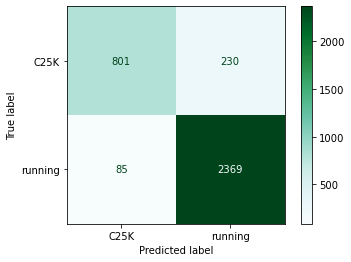

In [19]:
best_rf_preds = best_rf_gs[1].predict(best_rf_X_test)

best_rf_cm = confusion_matrix(best_rf_y_test, best_rf_preds)

best_rf_cm_disp = ConfusionMatrixDisplay(best_rf_cm, display_labels=["C25K", "running"])
best_rf_cm_disp.plot(cmap = "BuGn");

#### **Interpretation**: 
From our optimal row=7, here are the numbers for:  
Accuracy	Sensitivity	Specificity	Precision  
0.909613	0.965363	0.776916	0.911504

All look good, Sensitivity (True positive rate aka recall) is really high. The Precison is also good, so we wont spend any time on these and will focus on Specificity.   
The Specificity at 0.78 is not great. However, look at the range of Specificity across all the rows - we see that the lowest is 0.37 and this is the highest at 0.78. Again, we have seen a more than double improvement with our pre-processing! 

This is the crux of our analysis: 
We had expected to see quite poor accuracy because of the very similar nature of the 2 subreddits. Due to the insights gained during EDA, we were able to significantly improve the performance of the Random Forest model by utilizing more text and by using custom stop words. 

By adding the stop words common to both the subreddits,  we are able to separate the classes significantly. 

Interestingly, **75 words out of the top 100 are the common across both subreddits and 689 out of top 1000 are common in both!** No wonder classification is hard. 

Another interesting point to note: You'd think that adding more words to the stop words would be better. It does remove the overfit entirely at the cost of lower accuracy and lower Specificity. See the output of the below cell, the Training and Test scores drop (about 7%, and there is almost no overfit), **BUT the specificity drops tremendously** as our False Positives double. 

**We need to figure out what metric matters the most to us, if we are wiling to live with a larger number of False Positives maybe we go with lower accuracy but very low variance (less than 2%)**

Maybe we need to tune our pseudo-hyper-parameter some more and try Top 300 or Top 500 or....

In [20]:
mask = (full_results_df["Reddit Text Type"] == "title_selftext")
full_results_df[mask][["Reddit Text Type", "Stop Word Type", "Training Score", "Test Score", "Variance of Test vs Training Score", 
                       "Specificity", "FP"]]


,Reddit Text Type,Stop Word Type,Training Score,Test Score,Variance of Test vs Training Score,Specificity,FP
6,title_selftext,english,0.974940,0.912482,6.406357,0.758487,249
7,title_selftext,Top 100,0.957437,0.909613,4.995005,0.776916,230
8,title_selftext,Top 1000,0.882066,0.865710,1.854262,0.568380,445


#### Let's visualize all this with some  graphs

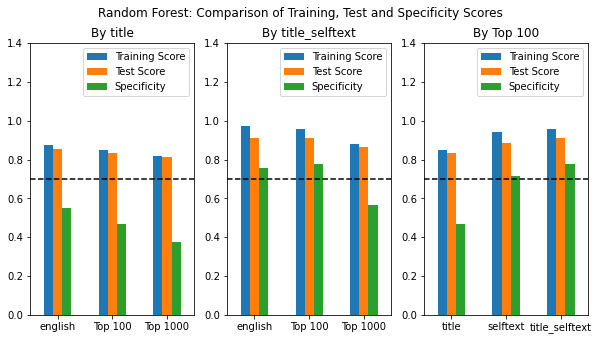

In [21]:
mask = (full_results_df["Reddit Text Type"] == "title")
mask_rf_df = full_results_df[mask][[ "Stop Word Type", "Training Score", "Test Score",  
                       "Specificity"]]


mask = (full_results_df["Reddit Text Type"] == "title_selftext")
ts_mask_rf_df = full_results_df[mask][[ "Stop Word Type", "Training Score", "Test Score",  
                       "Specificity"]]

mask = (full_results_df["Stop Word Type"] == "Top 100")
st_mask_rf_df = full_results_df[mask][[ "Reddit Text Type", "Training Score", "Test Score",  
                       "Specificity"]]




plt.figure(figsize=(10,5));
plt.suptitle( "Random Forest: Comparison of Training, Test and Specificity Scores")


ax1 = plt.subplot(1, 3, 1)
mask_rf_df.plot.bar(ax=ax1)

plt.axhline(0.7, color = 'black', linestyle = '--' )
plt.xticks([0, 1, 2 ], mask_rf_df["Stop Word Type"], rotation=0);

plt.ylim(0, 1.4); # to make sure the legend doesn't overlap the bars
plt.title("By title")


ax2 = plt.subplot(1, 3, 2)
ts_mask_rf_df.plot.bar(ax=ax2)

plt.axhline(0.7, color = 'black', linestyle = '--' )
plt.xticks([0, 1, 2 ], ts_mask_rf_df["Stop Word Type"], rotation=0);

plt.ylim(0, 1.4); # to make sure the legend doesn't overlap the bars
plt.title("By title_selftext")


ax3 = plt.subplot(1, 3, 3)
st_mask_rf_df.plot.bar(ax=ax3)

plt.axhline(0.7, color = 'black', linestyle = '--' )
plt.xticks([0, 1, 2 ], st_mask_rf_df["Reddit Text Type"], rotation=0);

plt.title("By Top 100")


plt.ylim(0, 1.4); # to make sure the legend doesn't overlap the bars


plt.savefig("../data/rf_train_test_spec.png")

#### **Interpretation**: There's lots to look at here. 

1. The baseline score is 0.70 (majority class) (black dotted line).  All our iterations performed significantly better than baseline.  

2. The Training Score varies from 0.81 to 0.97, showing the wide impact our two pre-processing steps had! After using the finely tuned hyperparameters, we were still able to get an additional 20% improvement by using title_selftext and our Top 100 stop words list!

    If we had just used title as our predictor and used the Top 100 stop words (graph 1), we would have got Train/Test Scores of: 0.87 and 0.85. This is a decent score, not overfit, since we did of a lot of tuning of the hyperparameters to reduce the variance typically found in DecisionTree models. 

3. When changing from title to to title_selftext (graph 2), we see a marked improvement. The Training score is higher at 0.97, but the gap with the Testing score of 0.91 is a bit high, indicating this model is a bit overfit. This intuitively makes sense because we have a much larger corpus so it can easily get great accuracy (the optimal max_depth is 70, it got better Training highers at higher max_depths, but it also got more overfit, so I capped it at 70). 

4. With the Stop Word Type of Top 100 (graph 3, optimal), the Training Score of 0.96 is slightly lower meaning a little less accuracy, but the Test Score of 0.91 is closer. So, it is less overfit and should be able to do a better job with  predicting on new unseen data. 

    We are willing to increase the bias to reduce the variance to make better predictions. 

    We did great on improving accuracy as well as reducing the variance. That's not all. Let's check more metrics



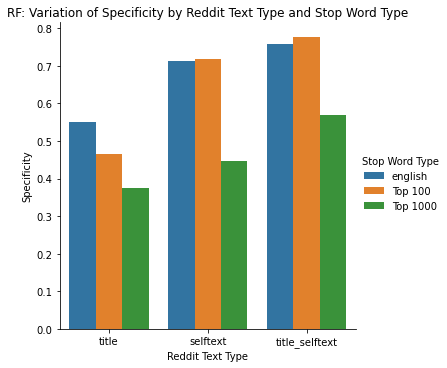

In [22]:
sns.catplot(data = full_results_df, kind = 'bar', x = 'Reddit Text Type', y = 'Specificity', hue = 'Stop Word Type').set(
    title = "RF: Variation of Specificity by Reddit Text Type and Stop Word Type");



#### **Interpretation**: The best Specificity at 0.78 is not great. However, look at the range of Specificity across all the rows - we see that the lowest is 0.37 and this is the highest at 0.78. Again, we have seen a more than double improvement with our pre-processing! 

This is the crux of our analysis: 
We had expected to see quite poor accuracy because of the very similar nature of the 2 subreddits. Due to the insights gained during EDA, we were able to significantly improve the performance of the Random Forest model by utilizing more text and by using custom stop words. 

By adding the stop words common to both the subreddits,  we are able to separate the classes significantly. 

Interestingly, **75 words out of the top 100 are the common across both subreddits and 689 out of top 1000 are common in both!** No wonder classification is hard. 

Another interesting point to note: You'd think that adding more words to the stop words would be better. It does remove the overfit entirely at the cost of lower accuracy and lower Specificity. See the output of the below cell, the Training and Test scores drop (about 7%, and there is almost no overfit), **BUT the specificity drops tremendously** as our False Positives double. 

**We need to figure out what metric matters the most to us, if we are willing to live with a larger number of False Positives maybe we go with lower accuracy but very low variance (less than 2%)**

Maybe we need to tune our pseudo-hyper-parameter some more and try Top 300 or Top 500 or....

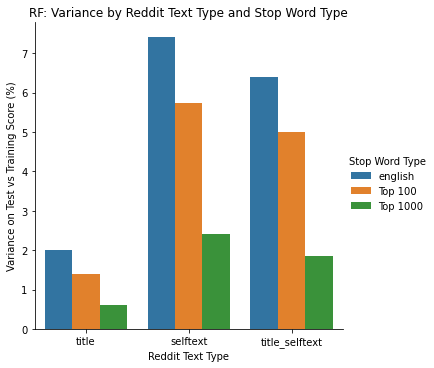

In [23]:
sns.catplot(data = full_results_df, kind = 'bar', x = 'Reddit Text Type', y = 'Variance of Test vs Training Score', hue = 'Stop Word Type').set(
    title = "RF: Variance by Reddit Text Type and Stop Word Type");

plt.ylabel("Variance on Test vs Training Score (%)");

#### **Interpretation**: If we want the least overfit model (lowest variance), we should pick the title and Stop 1000 combination. The percetage difference between the training and Test score is really low at 1.8%

In [24]:
mask_rf_df

,Stop Word Type,Training Score,Test Score,Specificity
0,english,0.873649,0.856241,0.549952
1,Top 100,0.846868,0.835007,0.466537
2,Top 1000,0.817217,0.812339,0.375364


ROC AUC Score: 0.9442538044341786


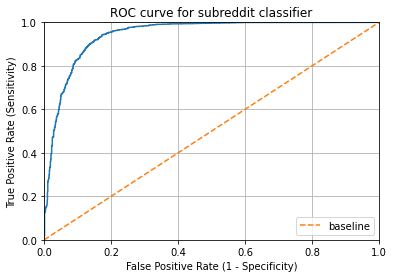

In [25]:
# Get the predicted probabilites
best_rf_preds_prob = best_rf_gs[1].predict_proba(best_rf_X_test)[:,1]

# Plot ROC curve

fpr, tpr, thresholds = roc_curve(best_rf_y_test, best_rf_preds_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for subreddit classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

print( f"ROC AUC Score: {roc_auc_score(best_rf_y_test, best_rf_preds_prob)}")


#### **Interpretation**: The ROC AUC score of 0.94 is high (close to the max of 1), as can also be seen by the area  under the curve.  
This shows that the positive and negative classes are quite well separated after choosing title_selftext and the Top 100 stop words. 



#### There's one more thing we should look at. 
Can we interpret anything from the predicted probabilities? 
For our predictions that are on the borderline say between 0.4 and 0.6, what can we do? Currently, we use the threshold of 0.5 and mark them as either running or c25k. 
If they are on the border, should we ask our Reddit moderators to cross-post them on both subreddits?


In [26]:
# Let's create a dataframe called pred_df that contains:
# 1. The true values of our test set.
# 2. The predicted probabilities based on our model.

best_rf_pred_df = pd.DataFrame({'true_values': best_rf_y_test,
                        'pred_probs': best_rf_preds_prob})

#best_rf_pred_df.head()

#### Plot distributions of predicted probabilities by actual values



/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


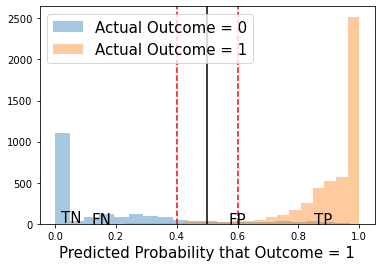

In [27]:

# Classification Metrics: Showing TP, TN, FP, FN on graph 

for group in best_rf_pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

# Add cutoff line
plt.axvline(0.5, color = 'black')
plt.axvline(0.4, color = 'red', linestyle = '--')
plt.axvline(0.6, color = 'red', linestyle = '--')

# Add annotations for TN, FN, TP, FP.
plt.annotate("TN", xy = (0.02, 15), size = 15)
plt.annotate("FN", xy = (0.12, 0), size = 15)
plt.annotate("TP", xy = (0.85, 1), size = 15)
plt.annotate("FP", xy = (0.57, 1), size = 15)

plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 15)
plt.legend(fontsize = 15);

plt.savefig("../images/rf_crosspost.png")

#### **Interpretation**:   
Orange bars to the right of 0.5 are all TP  
Orange bars to the left of 0.5 are all FN (predicted 0, actual 1)  
Blue bars to the left of 0.5 are the TN (predicted 0, actual 0)  
Blue bars to the right of 0.5 are the FP (predicted 1, actual 0)  



#### Unlike SVC, predicted probability matches with prediction. i.e. if predicted is < 0.5, predicted is 1 and vice-versa too


In [28]:
count_prob_positive = 0
count_prob_neg = 0

for i, p in enumerate( best_rf_preds ):
    if p == 1: 
        if best_rf_preds_prob[i] < 0.5: # not fp, but similar
#            print( i, p,  preds_prob[i],  y_test.iloc[i])
#            print (f"i: {i}, Predicted Prob: {round(preds_prob[i],2)}, Predicted: {preds[i]}, Actual: {y_test.iloc[i]}, Text: {X_test.iloc[i][:100]} ")
            count_prob_positive += 1
    else: # p = 0
        if best_rf_preds_prob[i] > 0.5: 
            count_prob_neg += 1

print( count_prob_positive, count_prob_neg )

0 0


#### Borderline scenario: If predicted proba is in range of 0.4 to 0.6, the classification can be considered to be non-definitive and hence can be posted in both subs

In [29]:
count = 0
for i in range(0, len(best_rf_preds_prob)):
    if (best_rf_preds_prob[i] < 0.6) and (best_rf_preds_prob[i] > 0.4):
        count = count + 1
        if count < 10: #print only the first 10 to avoid clutter 
            print (f"i: {i}, Predicted Prob: {round(best_rf_preds_prob[i],2)}, Predicted: {best_rf_preds[i]}, Actual: {y_test.iloc[i]}, Text: {X_test.iloc[i][:100]} ")
print (count)  # 246 out of 3485 where predicted prob was in range 0.4-0.6. These can be cross-posted



i: 17, Predicted Prob: 0.46, Predicted: 0, Actual: 1, Text: I've never been a runner, but yesterday I ran a mile in 10 minutes. How do I improve when my main fo 
i: 30, Predicted Prob: 0.48, Predicted: 0, Actual: 1, Text: Finally completed my first half marathon.\nUnfortunately, I had to do this by myself since there are 
i: 48, Predicted Prob: 0.58, Predicted: 1, Actual: 0, Text: Looking for Strava clubs!.\nHey, peeps! Anyone here walk or jog using Strava? I'm new to the app and 
i: 69, Predicted Prob: 0.41, Predicted: 0, Actual: 0, Text: Derailed by an injury.\nI was on such a roll going into W4 and feeling strong when I tweaked my back 
i: 76, Predicted Prob: 0.54, Predicted: 1, Actual: 0, Text: W9D1 was an epic fail..\nGot about 16 minutes into the run and had to stop to walk for 30 seconds. I 
i: 98, Predicted Prob: 0.41, Predicted: 0, Actual: 0, Text: Week 5 Day 3.\nI did ittttt!! I jogged for 20 minutes straight!!! It was at a 2.6 speed on the tread 
i: 100, Predicted Prob: 0.4,

In [30]:
# See example of borderline predict_proba. We got this wrong and should cross-post this. 
i = 17
print (f"i: {i}, Predicted Prob: {round(best_rf_preds_prob[i],2)}, Predicted: {best_rf_preds[i]}, Actual: {best_rf_y_test.iloc[i]}, Text: {best_rf_X_test.iloc[i][:500]} ")



i: 17, Predicted Prob: 0.46, Predicted: 0, Actual: 1, Text: I've never been a runner, but yesterday I ran a mile in 10 minutes. How do I improve when my main form of fitness is primarly strength?.\nI've always hated running. I would usually be out of breath after a few seconds. A few years ago I started getting fitter and was able to run longer distances at a slow pace without getting out of breath. But after that I got injured and lost my fitness. Now I've been working out again for two years but not as hard as before because I have to be careful cause  


#### **Interpretation**: Sounds like a classic example of a newbie runner. I’ve never been a runner. Our model predicted 0 (c25k) whereas it was in 1 (the running group). 
Though it seems we are wrong, if we cross-post this in the c25k group, the rookie runner will have deeper discussions with other newbie runners, increase upvotes and increase karma. 

This has the added advantage of reducing our False Positives and False Negatives by moving our threshold in each direction. Setting the red dotted bar to 0.4, will eliminate the above FN because it will now be posted to the c25k subreddit also. 


#### Now lets look at False positives


In [31]:
# print message text for the false positives (incorrectly classified c25k(0) as running (1)) 

# X_test[(y_pred_class==1) & (y_test==0)]
len(best_rf_X_test[(best_rf_preds == 1) & (best_rf_y_test == 0)])
##Alternatively, 
# X_test[preds > y_test]



230

#### Now lets look at False Negatives


In [32]:
# False negatives (incorrectly classified running(1) as c25k (0)) 

print( f"Len = {len(best_rf_X_test[(best_rf_preds == 0) & (best_rf_y_test == 1)])}\n")

#X_test[(preds == 0) & (y_test == 1)] # 94 False negatives, matches ConfusionMatrix

##Alternatively, 
# X_test[preds < y_test]



Len = 85



#### Yay!! Done with analysis for Random Forest



## Deep Dive for Support Vector Classifier <a class="anchor" id="Deep-Dive-for-Support-Vector-Classifier"></a>

#### Hyperparam tuning: 
This was the range of hyperparameters tried out. And yes, it was over multiple iterations spanning many many hours! SVC fits take longer than RandomForest, especially when we want to get the probability

        'cvec__max_df' : [ 0.97, 0.95, 0.93, 0.90],
        'cvec__max_features' : [ 2000, 3000, 4000, 6000, 10000],    
        'cvec__min_df' : [ 2, 3], 
        'cvec__ngram_range' : [(1, 3), (1, 2)],
        'cvec__stop_words' : ['english'], # this gets overridden in MetaGridSearch
    
        'svc__C': np.linspace(0.0001, 1, 20),
        'svc__degree' : [1, 2 ],
        'svc__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'svc__probability' : [ True, False ],    # takes much longer when we want to calculate probabilities
        'tfidf__use_idf': [True, False]


In [33]:
# These are the best params from all the above iterations: 

best_svc_gs[0].best_params_

{'cvec__max_df': 0.97,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__stop_words': 'english',
 'svc__C': 0.8889,
 'svc__degree': 2,
 'svc__kernel': 'sigmoid',
 'svc__probability': True,
 'tfidf__use_idf': True}

#### With the Top 100 stop words, we used the same params.   



#### Let's look at the results and draw ConfusionMatrix and analyze the Training/Test scores and other scores

In [34]:
svc_full_results_df # 9 rows for each combinaton of title, selftext and both with stop words of english, Top 100 and Top 1000


,Reddit Text Type,Stop Word Type,Baseline Score,Training Score,Test Score,Variance of Test vs Training Score,TN,FP,FN,TP,Accuracy,Sensitivity,Specificity,Precision,F1 Score,ROC AUC Score,Best Score,Model
0,title,english,0.704161,0.866858,0.857389,1.092354,591,440,57,2397,0.857389,0.976773,0.573230,0.844907,0.906067,0.869383,0.858250,SVC
1,title,Top 100,0.704161,0.852798,0.840459,1.446837,517,514,42,2412,0.840459,0.982885,0.501455,0.824334,0.896654,0.838206,0.841416,SVC
2,title,Top 1000,0.704161,0.828503,0.816069,1.500808,429,602,39,2415,0.816069,0.984108,0.416101,0.800464,0.882837,0.782476,0.812434,SVC
3,selftext,english,0.704161,0.909039,0.884648,2.683081,757,274,128,2326,0.884648,0.947840,0.734239,0.894615,0.920459,0.926414,0.891631,SVC
4,selftext,Top 100,0.704161,0.902343,0.887518,1.642993,750,281,111,2343,0.887518,0.954768,0.727449,0.892912,0.922804,0.922875,0.880440,SVC
5,selftext,Top 1000,0.704161,0.862363,0.823816,4.469831,545,486,128,2326,0.823816,0.947840,0.528613,0.827169,0.883403,0.852591,0.825634,SVC
6,title_selftext,english,0.704161,0.929794,0.915638,1.522477,815,216,78,2376,0.915638,0.968215,0.790495,0.916667,0.941736,0.952494,0.914395,SVC
7,title_selftext,Top 100,0.704161,0.921856,0.912769,0.985682,788,243,61,2393,0.912769,0.975143,0.764306,0.907815,0.940275,0.948127,0.905978,SVC
8,title_selftext,Top 1000,0.704161,0.890196,0.863702,2.976254,629,402,73,2381,0.863702,0.970253,0.610087,0.855552,0.909299,0.891381,0.863128,SVC


#### **Interpretation**: 

There's lots to look at here. 

The baseline score is 0.70 (majority class). 

The Training Score varies from 0.82 to 0.92, showing the wide impact our two pre-processing steps had. The title and english  stop words (which is our benchmark without our own psudo-hyper-params) came in at 0.87, so there is 4% improvement using title_selftext. In fact, the english slightly out-performs the model using our Top 100 in Training and Testing Score, but the variance is less with the Top 100. 

In most of the cases, the variance is super low, coming in as low as 0.98% - this indicates that our model should be able to predict well on new unseen data. 
The 2 best scenarios are rows 6 and 7, and they are pretty similar with row 6 having slightly higher Specificity scores. 
The variance percent is within the 2% tolerance for both, though row 7 is slightly better at 0.98 vs 1.5. 

We did good on improving accuracy as well as reducing the variance. That's not all. Let's check more metrics


#### Let's look at the Confusion Matrix

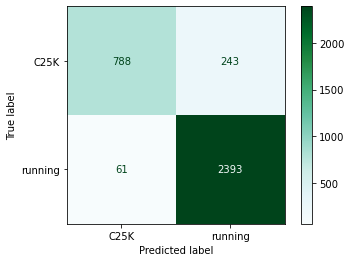

In [35]:
best_svc_preds = best_svc_gs[1].predict(best_svc_X_test)

best_svc_cm = confusion_matrix(best_svc_y_test, best_svc_preds)

best_svc_cm_disp = ConfusionMatrixDisplay(best_svc_cm, display_labels=["C25K", "running"])
best_svc_cm_disp.plot(cmap = "BuGn");

#### **Interpretation**: 
From our optimal row=7, here are the numbers for:  
Accuracy	Sensitivity	Specificity	Precision  
0.909613	0.965363	0.776916	0.911504

All look good, Sensitivity (True positive rate aka recall) is really high at 0.96. The Precision is also good, so we won't spend any time on these and will focus on Specificity.   
The Specificity at 0.78 is not great. However, look at the range of Specificity across all the rows - we see that the lowest is 0.41 and this is the highest at 0.78. Again, we have seen a more than double improvement with our pre-processing! 

This is the crux of our analysis: 
We had expected to see quite poor accuracy because of the very similar nature of the 2 subreddits. Due to the insights gained during EDA, we were able to significantly improve the performance of the Random Forest model by utilizing more text and by using custom stop words. 

By adding the stop words common to both the subreddits,  we are able to separate the classes significantly. 



In [36]:
mask = (svc_full_results_df["Reddit Text Type"] == "title_selftext")
svc_full_results_df[mask][["Reddit Text Type", "Stop Word Type", "Training Score", "Test Score", "Variance of Test vs Training Score", 
                       "Specificity", "FP"]]


,Reddit Text Type,Stop Word Type,Training Score,Test Score,Variance of Test vs Training Score,Specificity,FP
6,title_selftext,english,0.929794,0.915638,1.522477,0.790495,216
7,title_selftext,Top 100,0.921856,0.912769,0.985682,0.764306,243
8,title_selftext,Top 1000,0.890196,0.863702,2.976254,0.610087,402


#### Let's visualize all this with some  graphs

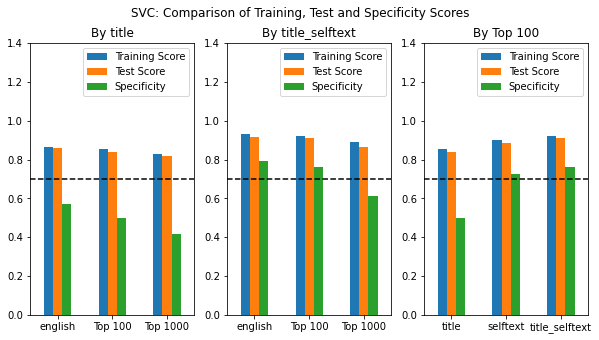

In [37]:
mask = (svc_full_results_df["Reddit Text Type"] == "title")
mask_svc_df = svc_full_results_df[mask][[ "Stop Word Type", "Training Score", "Test Score",  
                       "Specificity"]]


mask = (svc_full_results_df["Reddit Text Type"] == "title_selftext")
ts_mask_svc_df = svc_full_results_df[mask][[ "Stop Word Type", "Training Score", "Test Score",  
                       "Specificity"]]

mask = (svc_full_results_df["Stop Word Type"] == "Top 100")
st_mask_svc_df = svc_full_results_df[mask][[ "Reddit Text Type", "Training Score", "Test Score",  
                       "Specificity"]]




plt.figure(figsize=(10,5));
plt.suptitle( "SVC: Comparison of Training, Test and Specificity Scores")


ax1 = plt.subplot(1, 3, 1)
mask_svc_df.plot.bar(ax=ax1)

plt.axhline(0.7, color = 'black', linestyle = '--' )
plt.xticks([0, 1, 2 ], mask_svc_df["Stop Word Type"], rotation=0);

plt.ylim(0, 1.4); # to make sure the legend doesn't overlap the bars
plt.title("By title")


ax2 = plt.subplot(1, 3, 2)
ts_mask_svc_df.plot.bar(ax=ax2)

plt.axhline(0.7, color = 'black', linestyle = '--' )
plt.xticks([0, 1, 2 ], ts_mask_svc_df["Stop Word Type"], rotation=0);

plt.ylim(0, 1.4); # to make sure the legend doesn't overlap the bars
plt.title("By title_selftext")


ax3 = plt.subplot(1, 3, 3)
st_mask_svc_df.plot.bar(ax=ax3)

plt.axhline(0.7, color = 'black', linestyle = '--' )
plt.xticks([0, 1, 2 ], st_mask_svc_df["Reddit Text Type"], rotation=0);

plt.title("By Top 100")


plt.ylim(0, 1.4); # to make sure the legend doesn't overlap the bars

plt.savefig("../images/svc_train_test_spec.png")


#### **Interpretation**: There's lots to look at here. 

1. The baseline score is 0.70 (majority class) (black dotted line).  All our iterations performed significantly better than baseline.  

2. The Training Score varies from 0.81 to 0.97, showing the wide impact our two pre-processing steps had! After using the finely tuned hyperparameters, we were still able to get an additional 20% improvement by using title_selftext and our Top 100 stop words list!

    If we had just used title as our predictor and used the Top 100 stop words (graph 1), we would have got Train/Test Scores of: 0.87 and 0.85. This is a decent score, not overfit, since we did of a lot of tuning of the hyperparameters to reduce the variance typically found in DecisionTree models. 

3. When changing from title to to title_selftext (graph 2), we see a marked improvement. The Training score is higher at 0.97, but the gap with the Testing score of 0.91 is a bit high, indicating this model is a bit overfit. This intuitively makes sense because we have a much larger corpus so it can easily get great accuracy (the optimal max_depth is 70, it got better Training highers at higher max_depths, but it also got more overfit, so I capped it at 70). 

4. With the Stop Word Type of Top 100 (graph 3, optimal), the Training Score of 0.96 is slightly lower meaning a little less accuracy, but the Test Score of 0.91 is closer. So, it is less overfit and should be able to do a better job with  predicting on new unseen data. 

    We are willing to increase the bias to reduce the variance to make better predictions. 

    We did great on improving accuracy as well as reducing the variance. That's not all. Let's check more metrics



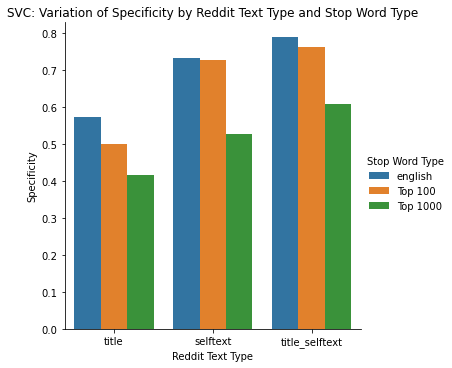

In [38]:
sns.catplot(data = svc_full_results_df, kind = 'bar', x = 'Reddit Text Type', y = 'Specificity', hue = 'Stop Word Type').set(
    title = "SVC: Variation of Specificity by Reddit Text Type and Stop Word Type");



#### **Interpretation**: The best Specificity at 0.78 is not great. However, look at the range of Specificity across all the rows - we see that the lowest is 0.37 and this is the highest at 0.78. Again, we have seen a more than double improvement with our pre-processing! 

This is the crux of our analysis: 
We had expected to see quite poor accuracy because of the very similar nature of the 2 subreddits. Due to the insights gained during EDA, we were able to significantly improve the performance of the Random Forest model by utilizing more text and by using custom stop words. 

By adding the stop words common to both the subreddits,  we are able to separate the classes significantly. 


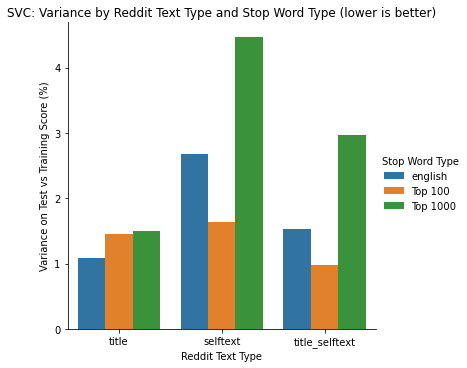

In [39]:
sns.catplot(data = svc_full_results_df, kind = 'bar', x = 'Reddit Text Type', y = 'Variance of Test vs Training Score', hue = 'Stop Word Type').set(
    title = "SVC: Variance by Reddit Text Type and Stop Word Type (lower is better)");

plt.ylabel("Variance on Test vs Training Score (%)");

#### **Interpretation**: If we want the least overfit model (lowest variance), we should pick the title and Stop 1000 combination. The percentage difference between the training and Test score is really low at 1.8%

In [40]:
mask_rf_df

,Stop Word Type,Training Score,Test Score,Specificity
0,english,0.873649,0.856241,0.549952
1,Top 100,0.846868,0.835007,0.466537
2,Top 1000,0.817217,0.812339,0.375364


ROC AUC Score: 0.9481272089274858


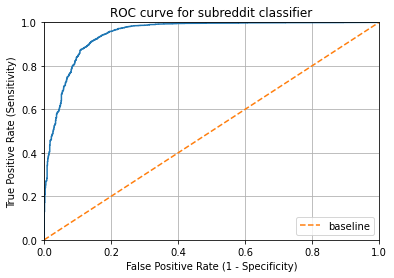

In [41]:
# Get the predicted probabilites
best_svc_preds_prob = best_svc_gs[1].predict_proba(best_svc_X_test)[:,1]

# Plot ROC curve

fpr, tpr, thresholds = roc_curve(best_svc_y_test, best_svc_preds_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for subreddit classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

print( f"ROC AUC Score: {roc_auc_score(best_svc_y_test, best_svc_preds_prob)}")

plt.savefig("../images/svc_roc_auc_curve.png") # save file to disk for use in presentation/readme

#### **Interpretation**: The ROC AUC score of 0.94 is high (close to the max of 1), as can also be seen by the area  under the curve.  
This shows that the positive and negative classes are quite well separated after choosing title_selftext and the Top 100 stop words. 



#### There's one more thing we should look at. 
Can we interpret anything from the predicted probabilities? 
For our predictions that are on the borderline say between 0.4 and 0.6, what can we do? Currently, we use the threshold of 0.5 and mark them as either running or c25k. 
If they are on the border, should we ask our Reddit moderators to cross-post them on both subreddits?


In [42]:
# Let's create a dataframe called pred_df that contains:
# 1. The true values of our test set.
# 2. The predicted probabilities based on our model.

best_svc_pred_df = pd.DataFrame({'true_values': best_svc_y_test,
                        'pred_probs': best_svc_preds_prob})

#best_svc_pred_df.head()

#### Plot distributions of predicted probabilities by actual values



/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


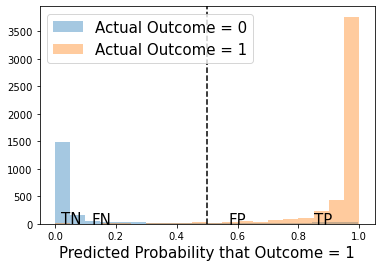

In [43]:

# Classification Metrics: Showing TP, TN, FP, FN on graph 

for group in best_svc_pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

# Add cutoff line
plt.axvline(0.5, color = 'black', linestyle = '--')

# Add annotations for TN, FN, TP, FP.
plt.annotate("TN", xy = (0.02, 15), size = 15)
plt.annotate("FN", xy = (0.12, 0), size = 15)
plt.annotate("TP", xy = (0.85, 1), size = 15)
plt.annotate("FP", xy = (0.57, 1), size = 15)

plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 15)
plt.legend(fontsize = 15);


#### **Interpretation**:   
Orange bars to the right of 0.5 are all TP  
Orange bars to the left of 0.5 are all FN (predicted 0, actual 1)  
Blue bars to the left of 0.5 are the TN (predicted 0, actual 0)  
Blue bars to the right of 0.5 are the FP (predicted 1, actual 0)  



#### In SVC, Predicted probability does not match with prediction. i.e. if predicted is < 0.5, predicted can be 1 and vice-versa too...
#### Interestingly, 60 cases where predicted is 1 and predicted proba is less than 0.5 
and 0 cases where predicted is 0 and proba is > 0.5



In [44]:
count_prob_positive = 0
count_prob_neg = 0

for i, p in enumerate( best_svc_preds ):
    if p == 1: 
        if best_svc_preds_prob[i] < 0.5: # not fp, but similar
#            print( i, p,  best_svc_preds_prob[i],  y_test.iloc[i])
#            print (f"i: {i}, Predicted Prob: {round(best_svc_preds_prob[i],2)}, Predicted: {best_svc_preds[i]}, Actual: {best_svc_y_test.iloc[i]}, Text: {best_svc_X_test.iloc[i][:100]} ")
            count_prob_positive += 1
    else: # p = 0
        if best_svc_preds_prob[i] > 0.5: 
            count_prob_neg += 1

print( count_prob_positive, count_prob_neg )

60 0


#### Borderline scenario: If predicted proba is in range of 0.4 to 0.6, the classification can be considered to be non-definitive and hence can be posted in both subs

In [45]:
count = 0
for i in range(0, len(best_svc_preds_prob)):
    if (best_svc_preds_prob[i] < 0.6) and (best_svc_preds_prob[i] > 0.4):
        count = count + 1
        if count < 10: #print only the first 10 to avoid clutter 
            print (f"i: {i}, Predicted Prob: {round(best_svc_preds_prob[i],2)}, Predicted: {best_svc_preds[i]}, Actual: {best_svc_y_test.iloc[i]}, Text: {best_svc_X_test.iloc[i][:100]} ")
print (count)  # 140 out of 3485 where predicted prob was in range 0.4-0.6. These can be cross-posted

# See row #4: i: 106, Predicted Prob: 0.47, Predicted: 1, Actual: 1: Even though the predicted proba was 0.47, it predicted 1


i: 17, Predicted Prob: 0.55, Predicted: 1, Actual: 1, Text: I've never been a runner, but yesterday I ran a mile in 10 minutes. How do I improve when my main fo 
i: 45, Predicted Prob: 0.56, Predicted: 1, Actual: 1, Text: I ran the most I ever have before. 17M - Asthmatic - Fasting.\nI'm 1.92m tall, 85kg, and fairly chub 
i: 53, Predicted Prob: 0.58, Predicted: 1, Actual: 1, Text: Strava segment etiquettes.\nWhat are your etiquettes or rules when it comes to earning KOMs/QOMs on  
i: 106, Predicted Prob: 0.47, Predicted: 1, Actual: 1, Text: I did everything wrong for my first half marathon. But I loved it!.\nI've hated running for as long  
i: 122, Predicted Prob: 0.55, Predicted: 1, Actual: 0, Text: Does Zenlabs Couch 2 5K include the warmup and warm down in the distance recorded?.\nI can’t find th 
i: 135, Predicted Prob: 0.47, Predicted: 1, Actual: 0, Text: Does anyone have doubt ever?.\nwhen i say doubt im on WK2D3 and im doing well, although it seems cra 
i: 159, Predicted Prob: 0

#### Now lets look at False positives


In [46]:
# print message text for the false positives (incorrectly classified c25k(0) as running (1)) 


len(best_svc_X_test[(best_svc_preds == 1) & (best_svc_y_test == 0)])
##Alternatively, 
# best_svc_X_test[best_svc_preds > best_svc_y_test]



243

#### Now lets look at False Negatives


In [47]:
# False negatives (incorrectly classified running(1) as c25k (0)) 

print( f"Len = {len(best_svc_X_test[(best_svc_preds == 0) & (best_svc_y_test == 1)])}\n")

#best_svc_X_test[(best_svc_preds == 0) & (best_svc_y_test == 1)] # 94 False negatives, matches ConfusionMatrix

##Alternatively, 
# best_svc_X_test[best_svc_preds < best_svc_y_test]



Len = 61



#### Yay!! Done with analysis for SVC too!



#### Lets look at all the 4 classifiers

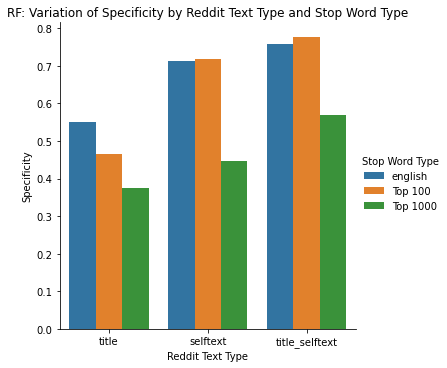

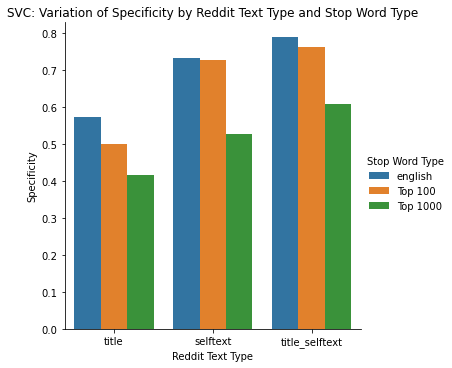

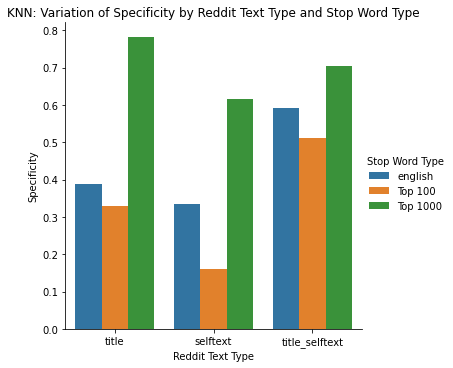

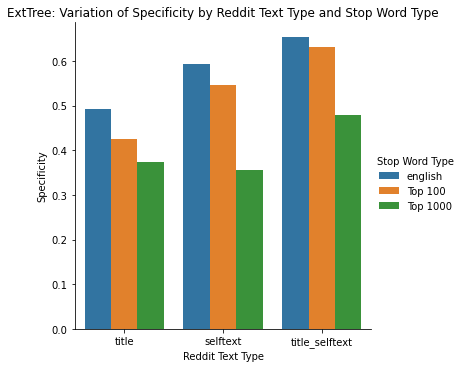

/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['running'] not in stop_words.
  warnings.warn(
/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['running'] not in stop_words.
  warnings.warn(
/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users

In [48]:
#plt.figure(figsize=(8,6));  #unable to remove the output below the cell even with the ';'

#ax1 = plt.subplot(2,2,1)



sns.catplot(data = full_results_df, kind = 'bar', x = 'Reddit Text Type', y = 'Specificity', hue = 'Stop Word Type').set(
    title = "RF: Variation of Specificity by Reddit Text Type and Stop Word Type");
sns.catplot(data = svc_full_results_df, kind = 'bar', x = 'Reddit Text Type', y = 'Specificity', hue = 'Stop Word Type').set(
    title = "SVC: Variation of Specificity by Reddit Text Type and Stop Word Type");
sns.catplot(data = knn_full_results_df, kind = 'bar', x = 'Reddit Text Type', y = 'Specificity', hue = 'Stop Word Type').set(
    title = "KNN: Variation of Specificity by Reddit Text Type and Stop Word Type");
sns.catplot(data = et_full_results_df, kind = 'bar', x = 'Reddit Text Type', y = 'Specificity', hue = 'Stop Word Type').set(
    title = "ExtTree: Variation of Specificity by Reddit Text Type and Stop Word Type");





plt.savefig( "../images/specificity_graph.png")  # Save to file so can use it in the ppt




#### We have completed the deep dive on Random Forest and SVC. Now we'll look across all the 4 classifications and pick the best performing classifier. 

#### End of notebook